# CNN

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [2]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
all_ann

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [4]:
all_ann["Filename"][2]

'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image1.png'

In [3]:
tmp = 0
path = "lib/datasets/LISA/"
file = all_ann["Filename"][0]
image = Image.open(path+file)
h, w = image.size
print(h,w)
print(all_ann["Lower right corner X"][tmp])
# left top right bottom
if all_ann["Upper left corner X"][tmp] > w - all_ann["Lower right corner X"][tmp]:
    image = image.crop((0,0,all_ann["Upper left corner X"][tmp],w))

else:
    image = image.crop((all_ann["Lower right corner X"][tmp],0,h,w))
image.show()

1024 522
916


In [30]:
image = image.crop((all_ann["Lower right corner X"][tmp],0,h,w))
image.show()

In [3]:
#max image size
# gt 260 400
height = 227
width = 227
data = []
labels = []
path = "lib/datasets/LISA/"
test = 0
import random
for i in range(len(all_ann["Filename"])-1000):
    file = all_ann["Filename"][i]
    sign = all_ann["Annotation tag"][i]
    image = Image.open(path+file)
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)

In [ ]:
for i in range(500):
    tmp = random.randint(0,7800)
    file = all_ann["Filename"][tmp]
    image = Image.open(path+file)
    h, w = image.size
    if all_ann["Upper left corner X"][tmp] > w - all_ann["Lower right corner X"][tmp]:
        image = image.crop((0,0,all_ann["Upper left corner X"][tmp],w))

    else:
        image = image.crop((all_ann["Lower right corner X"][tmp],0,h,w))
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append("None")

In [4]:
signs = np.array(data)
labels = np.array(labels)

# Randomize order
s = np.arange(signs.shape[0])
np.random.seed(43)
np.random.shuffle(s)
signs = signs[s]
labels = labels[s]

In [5]:
def one_hot(lab, vals):
    hot = []
    for i in range(len(vals)):
        # tmp = np.zeros(len(lab))
        # tmp[np.where(lab == i)] = 1
        hot.append(lab.tolist().index(vals[i]))
        # hot[i] = np.where(lab == vals[i])
        # hot.append(tmp)
    return hot

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import  RandomOverSampler
X_train, _, y_train, _ = train_test_split(signs, labels, test_size=0.2, random_state=1)
del signs
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [7]:
# Preprocess
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
#X_test = X_test.astype('float64')

# Normalize
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
#X_test -= mean_image

In [8]:
# Encode
lab = np.unique(labels)
from tensorflow.keras.utils import to_categorical
y_train_e = np.array(one_hot(lab,y_train))
#y_test_e = to_categorical(one_hot(lab,y_test),47)
y_val_e = np.array(one_hot(lab,y_val))

In [10]:
tmp = pd.DataFrame()
tmp["Label"] = lab
tmp["Encoding"] =list(range(len(lab)))
tmp.to_csv("App/lib/datasets/key1.csv",index=False)

## CNN models

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, ZeroPadding2D, BatchNormalization

### DevinNet
3x3 pool 3x3 pool 3x3 3x3 pool

In [30]:
model=Sequential()
#adding convolution layer
#model.add(ZeroPadding2D(padding=(2,2)))
## tone down this
model.add(Conv2D(32,(3,3),strides=1,activation='relu',input_shape=X_train.shape[1:]))
#model.add(MaxPool2D((2,2)))
#model.add(Dropout(rate=0.25))

model.add(Conv2D(64,(3,3),strides=1,activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(64,(3,3),strides=1,activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(len(lab),activation="softmax"))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
epochs = 12
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [14]:
model.save("App/lib/models/DevinNet")

INFO:tensorflow:Assets written to: App/lib/models/DevinNet\assets


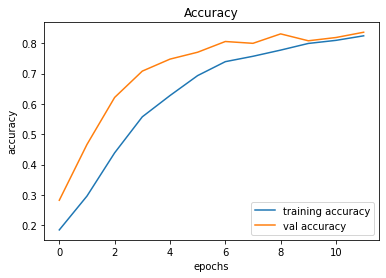

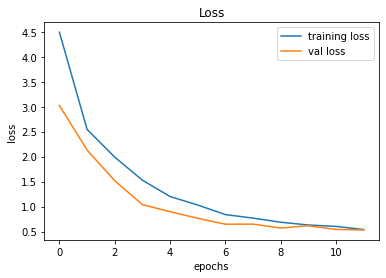

In [18]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['categorical_accuracy'], label='training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

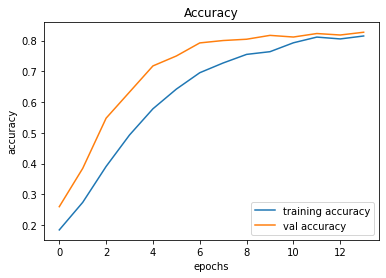

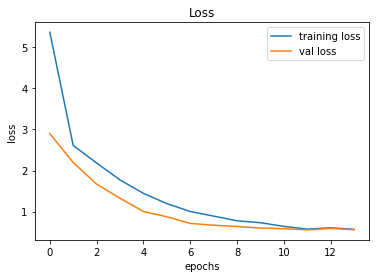

In [17]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [10]:
model=Sequential()
#adding convolution layer
model.add(Conv2D(32,(5,5),activation='relu',input_shape=X_train.shape[1:]))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(lab),activation='softmax'))
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
epochs = 20
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e))

NameError: name 'Sequential' is not defined

### AlexNet

In [29]:
tf.keras.backend.clear_session()

In [12]:
model=Sequential()
#adding convolution layer

model.add(Conv2D(96,(11,11),strides=4,activation='relu',input_shape=X_train.shape[1:],padding='valid'))
model.add(MaxPool2D((3,3),strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(256,(5,5),activation='relu',padding='same'))
model.add(MaxPool2D((3,3), strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(len(lab),activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),metrics=['accuracy'])
epochs = 40
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e))

Epoch 1/40
129/129 [==============================] - 24s 127ms/step - loss: 2.9887 - accuracy: 0.2234 - val_loss: 2.7376 - val_accuracy: 0.2487
Epoch 2/40
129/129 [==============================] - 11s 88ms/step - loss: 2.6822 - accuracy: 0.2791 - val_loss: 2.5191 - val_accuracy: 0.3012
Epoch 3/40
129/129 [==============================] - 11s 88ms/step - loss: 2.5061 - accuracy: 0.3185 - val_loss: 2.3309 - val_accuracy: 0.3384
Epoch 4/40
129/129 [==============================] - 11s 88ms/step - loss: 2.3343 - accuracy: 0.3603 - val_loss: 2.1286 - val_accuracy: 0.3807
Epoch 5/40
129/129 [==============================] - 11s 88ms/step - loss: 2.1386 - accuracy: 0.4109 - val_loss: 1.9492 - val_accuracy: 0.4581
Epoch 6/40
129/129 [==============================] - 11s 88ms/step - loss: 1.9855 - accuracy: 0.4486 - val_loss: 1.7560 - val_accuracy: 0.5128
Epoch 7/40
129/129 [==============================] - 11s 88ms/step - loss: 1.8121 - accuracy: 0.4846 - val_loss: 1.5882 - val_accuracy

In [14]:
model.save("App/lib/models/AlexNet")

INFO:tensorflow:Assets written to: App/lib/models/AlexNet\assets


### Another Version of AlexNet

In [13]:
tf.keras.backend.clear_session()
model=Sequential()
#adding convolution layer

model.add(Conv2D(96,(11,11),strides=4,activation='relu',input_shape=X_train.shape[1:]))
model.add(MaxPool2D((3,3),strides=2))
model.add(Dropout(rate=0.25))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(192,(5,5),strides=1,activation='relu',padding='valid'))
model.add(MaxPool2D((3,3), strides=2))
model.add(Dropout(rate=0.25))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),strides=1,activation='relu',padding='valid'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),strides=1,activation='relu',padding='valid'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(256,(3,3),strides=1,activation='relu',padding='valid'))

model.add(MaxPool2D((3,3), strides=2))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dense(4096,activation="relu"))
model.add(Dense(len(lab),activation="softmax"))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
epochs = 17
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e))

Epoch 1/17
148/148 [==============================] - 6s 38ms/step - loss: 12.9129 - accuracy: 0.2194 - val_loss: 2.8564 - val_accuracy: 0.2177
Epoch 2/17
148/148 [==============================] - 4s 27ms/step - loss: 2.8606 - accuracy: 0.2311 - val_loss: 2.8415 - val_accuracy: 0.2177
Epoch 3/17
148/148 [==============================] - 4s 26ms/step - loss: 2.8627 - accuracy: 0.2311 - val_loss: 2.8412 - val_accuracy: 0.2177
Epoch 4/17
 16/148 [==>...........................] - ETA: 3s - loss: 2.7482 - accuracy: 0.2676

KeyboardInterrupt: 

val_accuracy: 0.7810
3x3 3x3 val_accuracy: 0.7944
5x5 3x3 e = 8 val_accuracy: 0.7976
5x5 3x3 3x3 e = 8 val_accuracy: 0.8453
5x5 3x3 3x3 d = 256 val_accuracy: 0.8504
3x3 3x3 3x3 d = 256 val_accuracy: 0.8555
3x3 pool 3x3 pool 3x3 pool val_accuracy: 0.8791
3x3 pool 3x3 pool 3x3 3x3 pool val_accuracy: 0.8746